数据分析：
+ 总览
    ID:
    •Survived(存活与否)
    •Pclass（客舱等级，较为重要）
    •Name（姓名，可提取出更多信息）
    •Sex（性别，较为重要）
    •Age（年龄，较为重要）
    •Parch（直系亲友）
    •SibSp（旁系）
    •Ticket（票编号）
    •Fare（票价）
    •Cabin（客舱编号）
    •Embarked（上船的港口编号）
+ 使用统计学与绘图对数据初步分析
主要分析各类乘客存活率情况
（大致分为10类左右）
+ 数据清洗
填充缺失值（构建随机森林模型）
按姓氏等进行划分，之后同组之间进行识别，查看存活率情况
之后按存活率情况进行分组，挑出反常的一组
选取特征，进行特征转换，划分训练集与测试集
+ 建模和优化
网络搜索选最优参数，之后训练模型，最后交叉验证
+ 进行预测


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 总览

In [122]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
#连接
df_all = pd.concat([train, test]).reset_index(drop=True)
df_all.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [123]:
#查看
df_all.info()
df_all.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


从数据中可以发现有些属性存在null 

# 绘图分析

<AxesSubplot:xlabel='Survived', ylabel='Age'>

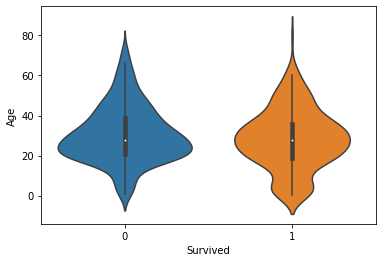

In [124]:
#获救的年龄分布 小提琴图
sns.violinplot(x='Survived',y='Age',data=train)

Text(0.5, 1.0, '生存概率')

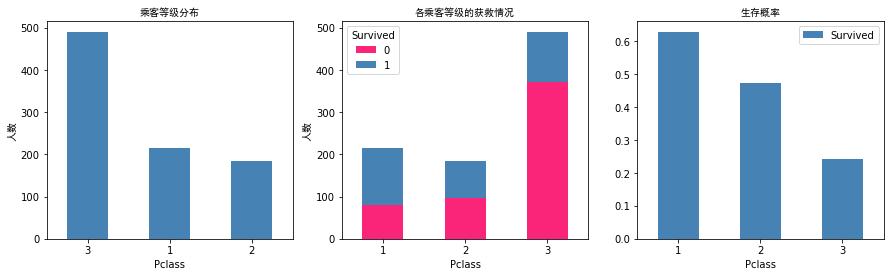

In [125]:
#等级更高 获救的几率越大
train_df = train
#画子图
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,4))

train_df.Pclass.value_counts().plot(kind="bar",color='steelblue',ax=axis1)
axis1.set_xticklabels([3,1,2],rotation=0)
axis1.set_ylabel(u'人数',fontproperties='SimHei')
axis1.set_xlabel('Pclass')

#两组数据分类并画图
pd.crosstab(train_df.Pclass,train_df.Survived).plot.bar(stacked=True,color=['#FA2479','steelblue'],ax=axis2)
axis2.set_xticklabels([1,2,3], rotation=0)
axis2.set_ylabel(u'人数',fontproperties='SimHei')

#柱状图
pd.pivot_table(train_df,index=['Pclass'],values=['Survived']).plot.bar(ax=axis3,color='steelblue')
axis3.set_xticklabels([1,2,3], rotation=0)

axis1.set_title(u"乘客等级分布",fontproperties='SimHei')
axis2.set_title(u"各乘客等级的获救情况",fontproperties='SimHei')
axis3.set_title(u"生存概率",fontproperties='SimHei')

Text(0.5, 1.0, '生存概率')

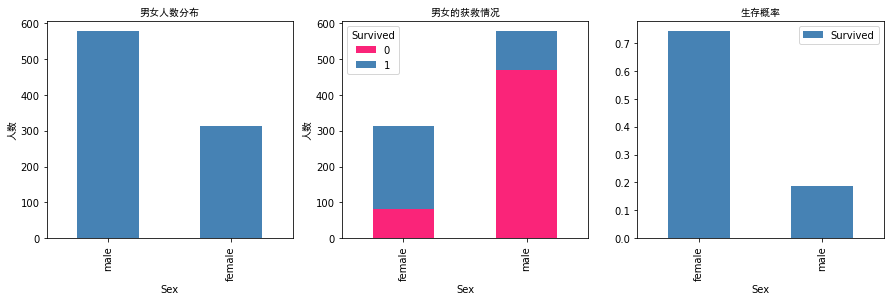

In [126]:
#女生获救概率更高
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,4))

train_df.Sex.value_counts().plot(kind="bar",color='steelblue',ax=axis1)
axis1.set_ylabel(u'人数',fontproperties='SimHei')
axis1.set_xlabel('Sex')


pd.crosstab(train_df.Sex,train_df.Survived).plot.bar(stacked=True,color=['#FA2479','steelblue'],ax=axis2)
axis2.set_ylabel(u'人数',fontproperties='SimHei')


pd.pivot_table(train_df,index=['Sex'],values=['Survived']).plot.bar(ax=axis3,color='steelblue')

axis1.set_title(u"男女人数分布",fontproperties='SimHei')
axis2.set_title(u"男女的获救情况",fontproperties='SimHei')
axis3.set_title(u"生存概率",fontproperties='SimHei')


In [ ]:
#有旁系亲友存活率高
sns.barplot(x="SibSp", y="Survived", data=train)

#I won't be printing individual percent values for all of these.
print("Percentage of SibSp = 0 who survived:", train["Survived"][train["SibSp"] == 0].value_counts(normalize = True)[1]*100)

print("Percentage of SibSp = 1 who survived:", train["Survived"][train["SibSp"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of SibSp = 2 who survived:", train["Survived"][train["SibSp"] == 2].value_counts(normalize = True)[1]*100)

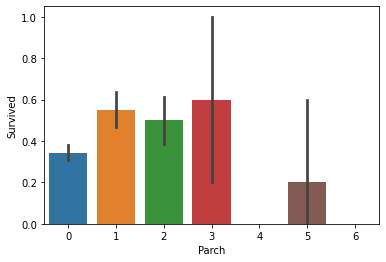

In [128]:
#有一个兄弟姐妹的一般有更高的生存率
#draw a bar plot for Parch vs. survival
sns.barplot(x="Parch", y="Survived", data=train)
plt.show()

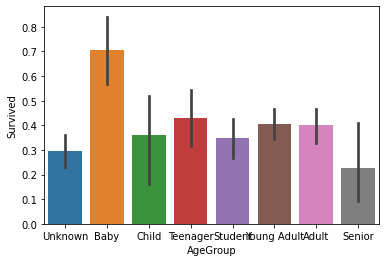

In [129]:
#婴儿的生存率奇高
#-0.5填充缺失值
train["Age"] = train["Age"].fillna(-0.5)
test["Age"] = test["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
#数据分箱 分成labels几类
train['AgeGroup'] = pd.cut(train["Age"], bins, labels = labels)
test['AgeGroup'] = pd.cut(test["Age"], bins, labels = labels)

sns.barplot(x="AgeGroup", y="Survived", data=train)
plt.show()

Text(28.070905671296288, 0.5, 'density')

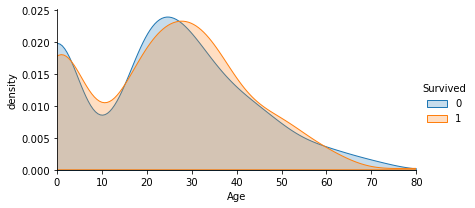

In [130]:
#age 
facet = sns.FacetGrid(train_df, hue='Survived', aspect=2)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.xlabel('Age')
plt.ylabel('density')

Percentage of CabinBool = 1 who survived: 66.66666666666666
Percentage of CabinBool = 0 who survived: 29.985443959243085


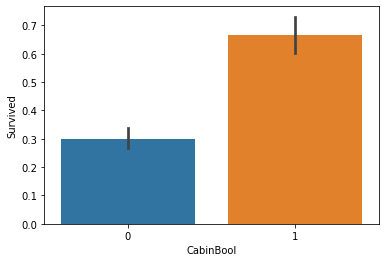

In [131]:
#cabin中存活率 有cabin存活率高
train["CabinBool"] = (train["Cabin"].notnull().astype('int'))
test["CabinBool"] = (test["Cabin"].notnull().astype('int'))

print("Percentage of CabinBool = 1 who survived:", train["Survived"][train["CabinBool"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of CabinBool = 0 who survived:", train["Survived"][train["CabinBool"] == 0].value_counts(normalize = True)[1]*100)
sns.barplot(x="CabinBool", y="Survived", data=train)
plt.show()

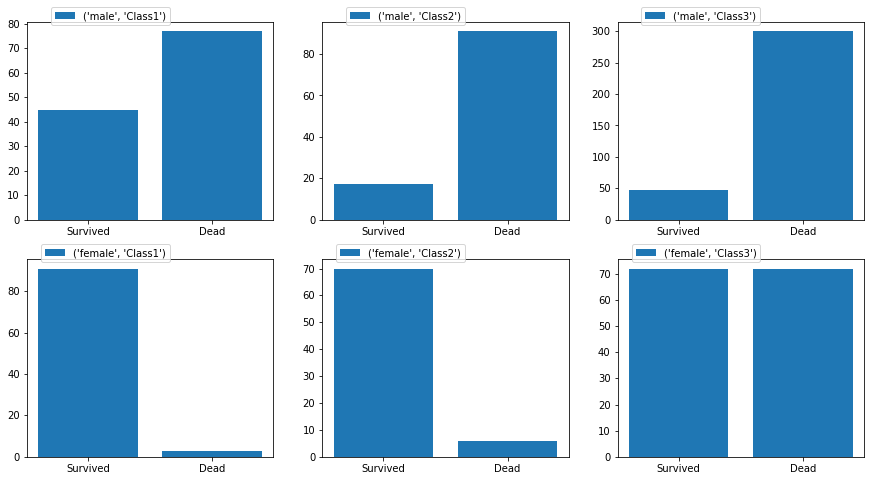

In [132]:
#性别 仓等级与存活率关系
full = df_all
fig,axes=plt.subplots(2,3,figsize=(15,8))
Sex1=['male','female']
for i,ax in zip(Sex1,axes):
    for j,pp in zip(range(1,4),ax):
        PclassSex=full[(full.Sex==i)&(full.Pclass==j)]['Survived'].value_counts().sort_index(ascending=False)
        pp.bar(range(len(PclassSex)),PclassSex,label=(i,'Class'+str(j)))
        pp.set_xticks((0,1))
        pp.set_xticklabels(('Survived','Dead'))
        pp.legend(bbox_to_anchor=(0.6,1.1))

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

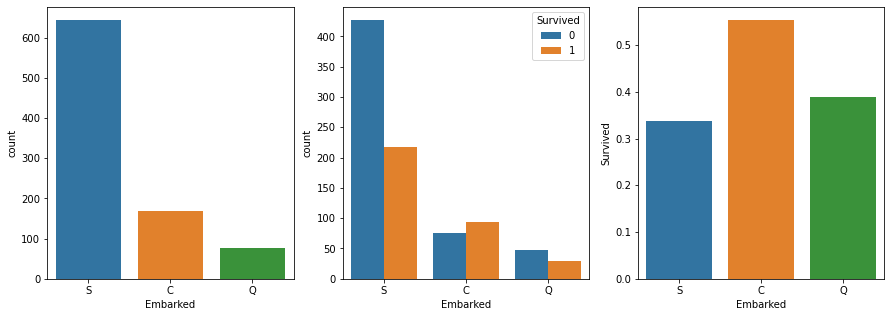

In [133]:
#从图中可以看出，途径港口上船的人生存几率较大
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

sns.countplot(x='Embarked', data=train_df,order=['S','C','Q'], ax=axis1)

sns.countplot(x='Embarked', hue="Survived", data=train_df, order=['S','C','Q'], ax=axis2)

embark_perc = train_df[["Embarked","Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

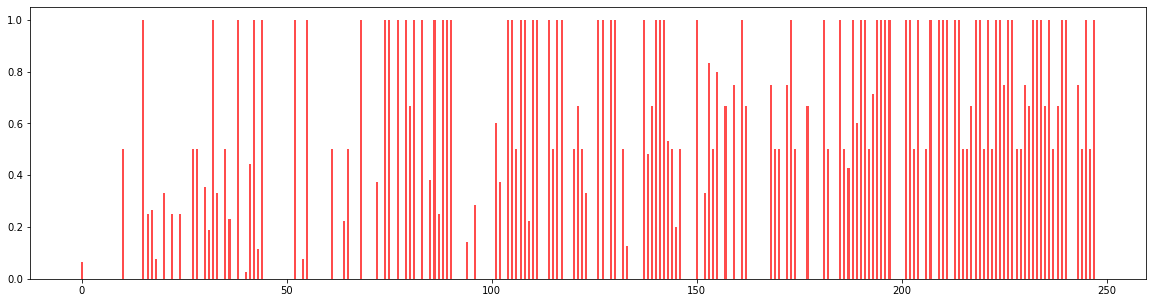

In [134]:
#票价存活率
fare = train[['Fare', 'Survived']].groupby(['Fare']).mean()
index = fare.shape
plt.figure(2, figsize=(20,5))
plt.bar(
    range(index[0]),
    fare.values.reshape(-1),
    0.5,
    color='r',
    alpha=0.7
)
# plt.axis([0,80,0,2])
plt.xticks()
plt.show()

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

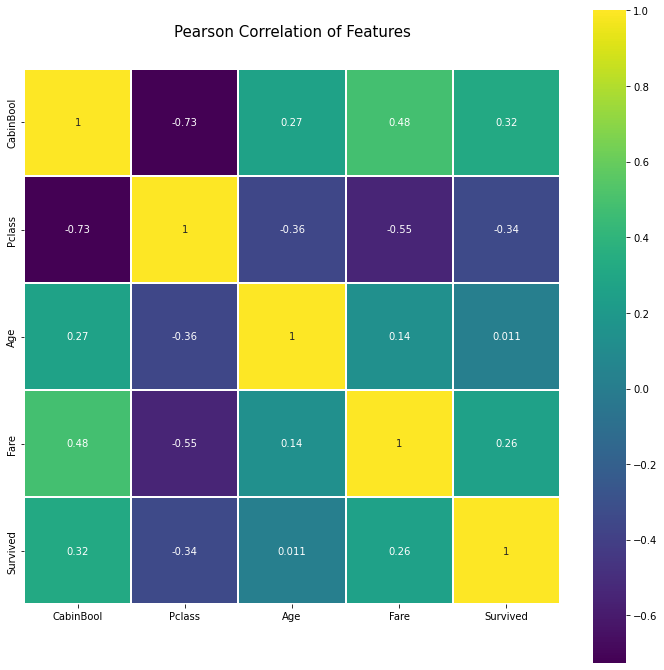

In [135]:
#热力图
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
vari=train[['CabinBool','Pclass','Age','Fare','Survived']]

sns.heatmap(vari.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

# 数据清理

In [168]:
# 查看缺失值
data_train=pd.read_csv('train.csv')
data_test=pd.read_csv('test.csv')

(418, 11)

In [149]:
#用scikit-learn中的RandomForest来拟合一下缺失的年龄数据，
# 用RandomForest在原始数据中做不同采样，建立多颗DecisionTree，再进行average等等来降低过拟合现象
from sklearn.ensemble import RandomForestRegressor
 
### 使用 RandomForestClassifier 填补缺失的年龄属性
def set_missing_ages(df):
    
    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    age_df = df[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]

    # 乘客分成已知年龄和未知年龄两部分
    known_age = age_df[age_df.Age.notnull()].values
    unknown_age = age_df[age_df.Age.isnull()].values

    # y即目标年龄，known age是一个特征矩阵，第一行是age，其他行以用特征属性值，这里取了第一行
    y = known_age[:, 0]

    # X即特征属性值
    X = known_age[:, 1:]

    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)
    
    # 用得到的模型进行未知年龄结果预测
    predictedAges = rfr.predict(unknown_age[:, 1::])
    
    # 用得到的预测结果填补原缺失数据
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    
    return df, rfr

def set_Cabin_type(df):
    df.loc[ (df.Cabin.notnull()), 'Cabin' ] = "Yes"
    df.loc[ (df.Cabin.isnull()), 'Cabin' ] = "No"
    return df

data_train, rfr = set_missing_ages(data_train)
data_train = set_Cabin_type(data_train)

In [150]:
#对其进行one-hot编码
dummies_Cabin = pd.get_dummies(data_train['Cabin'], prefix= 'Cabin')      

dummies_Embarked = pd.get_dummies(data_train['Embarked'], prefix= 'Embarked')

dummies_Sex = pd.get_dummies(data_train['Sex'], prefix= 'Sex')

dummies_Pclass = pd.get_dummies(data_train['Pclass'], prefix= 'Pclass')

df = pd.concat([data_train, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
df

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,1,0,22.000000,1,0,7.2500,1,0,0,0,1,0,1,0,0,1
1,2,1,38.000000,1,0,71.2833,0,1,1,0,0,1,0,1,0,0
2,3,1,26.000000,0,0,7.9250,1,0,0,0,1,1,0,0,0,1
3,4,1,35.000000,1,0,53.1000,0,1,0,0,1,1,0,1,0,0
4,5,0,35.000000,0,0,8.0500,1,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,27.000000,0,0,13.0000,1,0,0,0,1,0,1,0,1,0
887,888,1,19.000000,0,0,30.0000,0,1,0,0,1,1,0,1,0,0
888,889,0,16.185117,1,2,23.4500,1,0,0,0,1,1,0,0,0,1
889,890,1,26.000000,0,0,30.0000,0,1,1,0,0,0,1,1,0,0


In [151]:
#归一化
import sklearn.preprocessing as preprocessing  
scaler = preprocessing.StandardScaler()
age_scale_param = scaler.fit(df['Age'].values.reshape(-1,1))
df['Age_scaled'] = scaler.fit_transform(df['Age'].values.reshape(-1,1), age_scale_param)
fare_scale_param = scaler.fit(df['Fare'].values.reshape(-1,1))
df['Fare_scaled'] = scaler.fit_transform(df['Fare'].values.reshape(-1,1), fare_scale_param)
df.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Age_scaled,Fare_scaled
0,1,0,22.0,1,0,7.2500,1,0,0,0,1,0,1,0,0,1,-0.561377,-0.502445
1,2,1,38.0,1,0,71.2833,0,1,1,0,0,1,0,1,0,0,0.613173,0.786845
2,3,1,26.0,0,0,7.9250,1,0,0,0,1,1,0,0,0,1,-0.267740,-0.488854
3,4,1,35.0,1,0,53.1000,0,1,0,0,1,1,0,1,0,0,0.392945,0.420730
4,5,0,35.0,0,0,8.0500,1,0,0,0,1,0,1,0,0,1,0.392945,-0.486337


In [185]:
data_test.loc[ (data_test.Fare.isnull()), 'Fare' ] = 0

# 接着我们对test_data做和train_data中一致的特征变换
# 首先用同样的RandomForestRegressor模型填上丢失的年龄

tmp_df = data_test[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
null_age = tmp_df[data_test.Age.isnull()].values

# 根据特征属性X预测年龄并补上
X_1 = null_age[:, 1:]
predictedAges = rfr.predict(X_1)
data_test.loc[ (data_test.Age.isnull()), 'Age' ] = predictedAges

data_test = set_Cabin_type(data_test)
dummies_Cabin = pd.get_dummies(data_test['Cabin'], prefix= 'Cabin')
dummies_Embarked = pd.get_dummies(data_test['Embarked'], prefix= 'Embarked')
dummies_Sex = pd.get_dummies(data_test['Sex'], prefix= 'Sex')
dummies_Pclass = pd.get_dummies(data_test['Pclass'], prefix= 'Pclass')


df_test = pd.concat([data_test, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
df_test.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
df_test['Age_scaled'] = scaler.fit_transform(df_test['Age'].values.reshape(-1,1), age_scale_param)
df_test['Fare_scaled'] = scaler.fit_transform(df_test['Fare'].values.reshape(-1,1), fare_scale_param)
df_test.head()

ValueError: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required.

In [167]:
test = df_test.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
data_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.500000,0,0,330911,7.8292,No,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,363272,7.0000,No,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,240276,9.6875,No,Q
3,895,3,"Wirz, Mr. Albert",male,27.000000,0,0,315154,8.6625,No,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,3101298,12.2875,No,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,30.705727,0,0,A.5. 3236,8.0500,No,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,Yes,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,No,S
416,1308,3,"Ware, Mr. Frederick",male,30.705727,0,0,359309,8.0500,No,S


# 建模优化

In [186]:
from sklearn import linear_model #就是调用线性回归方程，机械化的操作，并不是很难。

# 用正则取出我们要的属性值
train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
# train_np = train_df.values
from sklearn.model_selection import train_test_split

predictors = train_df.drop(['Survived'], axis=1)
target = train_df["Survived"]
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.22, random_state = 0)

# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_val)
acc_gaussian = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gaussian)

# Support Vector Machines
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_val)
acc_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_svc)
# Linear SVC
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
y_pred = linear_svc.predict(x_val)
acc_linear_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_linear_svc)
# Perceptron
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(x_train, y_train)
y_pred = perceptron.predict(x_val)
acc_perceptron = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_perceptron)
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_val)
acc_decisiontree = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_decisiontree)
# Random Forest
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)
# KNN or k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_val)
acc_knn = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_knn)
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_val)
acc_sgd = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_sgd)
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gbk = GradientBoostingClassifier()
gbk.fit(x_train, y_train)
y_pred = gbk.predict(x_val)
acc_gbk = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gbk)

# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)
acc_logreg = round(accuracy_score(y_pred, y_val) * 100, 2)

print(acc_logreg)
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 'Linear SVC', 
              'Decision Tree', 'Stochastic Gradient Descent', 'Gradient Boosting Classifier'],
    'Score': [acc_svc, acc_knn, acc_logreg, 
              acc_randomforest, acc_gaussian, acc_perceptron,acc_linear_svc, acc_decisiontree,
              acc_sgd, acc_gbk]})
models.sort_values(by='Score', ascending=False)

80.2
80.71
81.73
79.7
82.23
84.77
80.71
80.71


D:\4_code\1_anaconda\envs\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


87.31


,Model,Score
9,Gradient Boosting Classifier,87.31
3,Random Forest,84.77
2,Logistic Regression,82.23
7,Decision Tree,82.23
6,Linear SVC,81.73
0,Support Vector Machines,80.71
1,KNN,80.71
8,Stochastic Gradient Descent,80.71
4,Naive Bayes,80.20
5,Perceptron,79.70


In [179]:
#网格搜索 
from sklearn.model_selection import GridSearchCV
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=300,
                                  min_samples_leaf=20,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',cv=5)
gsearch1.fit(x_train, y_train)
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 80}, 0.8504353187816006)

# 预测

In [183]:
gbk = GradientBoostingClassifier(n_estimators = 80)
gbk.fit(x_train, y_train)
predictions = gbk.predict(test)
predictions
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].values, 'Survived':predictions.astype(np.int32)})
result.to_csv("logical.csv", index=False)